## Mini-Projet: Séparation de sources hyperspectrale

Une image hyperspectrale est une image où un spectre contenant $D$ valeurs ou canaux est enregistré à chaque pixel. Cette modalité d'imagerie est très utilisée en imagerie satellitaire, où elle permet d'améliorer considérablement la résolution de la prise d'image. Dans le cas des images satellitaires, les pixels de l'image ont ainsi une résolution spatiale de l'ordre de la dizaine de mètres, de sorte que ces pixels mélangent les contributions des différents éléments présents sur la scène imagée (végétation, eau, minéraux du sol, habitations, routes, etc.). Nous nous intéressons ici à un problème, connu sous le nom de séparation de sources hyperspectrale, qui vise à identifier, pour une observation donnée, les spectres des constituants élémentaires présents dans une scène, ainsi que la proportion ("l'abondance") de ces constituants en chaque pixel de l'image.

L'objectif de ce mini-projet est d'implémenter un algorithme de séparation de source hyperspectral et de l'appliquer à une image satellitaire issue de la base de donnée SAMSON. L'image en question est de taille 95 x 95 pixels. Chaque pixel correspond à un spectre de 156 canaux, qui couvrent un intervalle de longueurs d'onde qui s'étend de 401 à 889 nm. La résolution spectrale est de 3.13 nm. Chaque spectre Y(x, y) mesuré au niveau du pixel (x, y) de l'image correspond à la combinaison linéaire des spectres *élémentaires* associés à l'eau, à la végétation et aux minéraux présents dans le sol:

$$
Y[x, y] = \alpha_{1} [x, y] m_1 + \alpha_2 [x, y] m_2 + (1 - \alpha_1[x, y] - \alpha_2[x, y]) m_3,
$$

où $\alpha_1[x, y]$ et $\alpha_2[x, y]$ correspondent aux proportions relatives d'eau et de végétation en surface à la position $[x, y]$, et $m_1$, $m_2$ et $m_3$ correspondent aux spectres élémentaires de l'eau, de la végétation et du sol minéral respectivement.



In [232]:
# -*- Encoding: Latin-1 -*-
#!/usr/bin/python

from math import *
import random
import copy
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.linalg import eigh, det, norm

In [233]:
data_dict = loadmat("Samson.mat")
a = data_dict['A'].reshape((95*95, 3))
end = data_dict['M']
data = np.dot(a, end.T)

## 1. Visualisation des données

Le script ci-dessous permet de charger les données de l'image. Implémenter une fonction python permettant de visualiser:
- le spectre mesuré en un pixel de l'image
- l'image obtenue à une longueur d'onde donnée

In [234]:
def display_spectrum(img, loc, show=True):
    
    """
    Display the spectrum at location (x, y)
    
    :param img: Hyperspectral image
    :type img: 3D numpy array
    :param loc: Pixel location
    :type loc: tuple
    
    """
    x, y = loc
    lb = np.arange(401e-9, 889e-9, 3.13e-9)
    
    if (show):
        plt.plot(lb, img[x,y])
        plt.show()
    else:
        plt.plot(lb, img[x,y], '-+')
        return lb

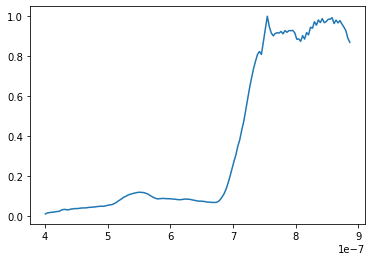

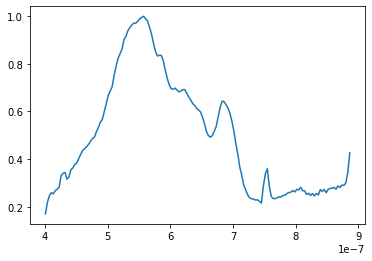

In [235]:
display_spectrum(data.reshape((95, 95, 156)), (50, 50))
display_spectrum(data.reshape((95, 95, 156)), (0, 0))

In [236]:
def display_band(img, spectr_idx):
    
    """
    Display the image corresponding to the specified spectral band
    
    :param img: Hyperspectral image
    :type img: 3D numpy array
    :param spectr_idx: Indexof the spectral band to display
    :type spectr_idx: int
    
    """
    bd = img[:,:,spectr_idx]
    im0 = plt.imshow(bd)
    plt.gcf().colorbar(im0)
    plt.show()

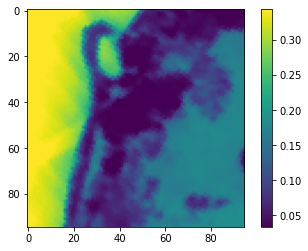

In [237]:
display_band(data.reshape((95, 95, 156)), 10) # 10, 100, 150 très différent

## 2. Réduction de dimension

Les spectres observés dans les données sont des vecteurs de dimension $D = 156$ et peuvent donc être représentées dans l'espace vectoriel $\mathbb{R}^D$. Ces spectres correspondent cependant à la combinaison linéaire de $K = 3$ spectres élémentaires, pondérés par les quantités positives $\alpha _1$, $\alpha_2$ et $\alpha_3$, qui correspondent à la proportion relative de chacun des spectres élémentaires. Par ailleurs, on a la relation de liaison supplémentaire:

$$
\alpha_1 + \alpha_2 + \alpha_3 = 1.
$$

Compte tenu de ces différentes relations, est-il possible de réduire la dimension des données, c'est à dire de déterminer un sous-espace de $\mathbb{R}^D$ qui contienne l'ensemble des points de données ? Quelle serait la dimension de cet espace ? En utilisant l'algorithme d'analyse en composantes principales (ACP, ou PCA en anglais) présenté dans les slides accompagnant le mini-projet, identifier le sous-espace en question. Projeter les données spectrales dans ce sous-espace, et afficher le résultat. Commenter le résultat. En particulier, comment explique-t-on la distribution géométrique des données spectrales?


In [238]:
def pca(data, K):
    """
    Principal component analysis (PCA)
    """

    N = len(data)

    # Compute the covariance matrix and the mean of the data
    m=np.mean(data,axis=0)
    C=np.cov(data.T)
    
    # Computes the eigenvalues/eigenvectors of the covariance matrix
    # Extract the K largest eigenvectors
    L = len(m)
    vals, vecs = eigh(C, subset_by_index=[L-K, L-1])  
        
    # Project the data on the subpasce spanned by the K largest eigenvectors
    u = np.stack(vecs, axis=0).T
    Y = np.matmul(u, data.T-np.multiply(m[:,np.newaxis], np.ones(N)))
    return Y.T

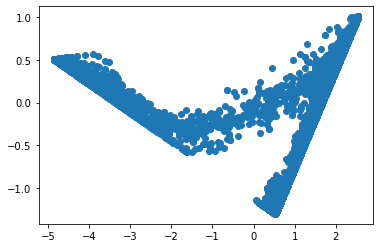

In [239]:
# plot the projected data
projected_data = pca(data, K=2)
plt.scatter(projected_data[:,1],projected_data[:,0]) # inversion x et y
plt.show()

# 3. Détermination des spectres élémentaires

Dans l'espace de dimension réduite déterminé dans la question précédente, les données spectrales prennent la forme géométrique d'un simplexe. Les sommets de ce simplexe correspondent aux spectres élémentaires présents dans la scène. Implémenter l'algorithme N-FINDR décrit dans les slides accompagnant le mini-projet pour déterminer les spectres élémentaires.



In [240]:
class nfindr:

    """
    NFINDR algorithm implementation
    """

    def __init__(self, projected_data, R):

        """
        Constructor

        :param projected_data: Projected data points
        :param R: Number of endmembers
        :type projected_data: Numpy array 
        :type R: int
        """

        self.projected_data = projected_data
        self.N, self.K = self.projected_data.shape    
        self.R = R 


    def set_endmembers(self):

        """
        Initialize the NFINDR algorithm 
        """

        # Randomly select R endmembers from the data points
        self.idx = np.random.choice(self.N, self.R, replace=False)
        self.endmembers = self.projected_data[self.idx, :]

        # Compute the volume of the simplex
        self.volume = self.calc_vol(self.endmembers)
        
    def calc_vol(self, endm):
        e = np.copy(endm)
        e = e[1:]-e[0]

        # Compute the volume of the simplex
        return np.abs(det(e)) # pas besoin de R, facteur de proportionnalité...

    def iterate(self):

        """
        N-FINDR Iteration
        """

        # Iterate over the endmembers
        modif = False
        for p in range(self.R):
            end = np.copy(self.endmembers)

            # Iterate over the data points
            for q in range(self.N):

                # Try replacing the selected endmember by the data point
                new_pt = self.projected_data[q]
                if (not self.projected_data[q] in end):
                    end[p] = new_pt
                    v = self.calc_vol(end)

                    # Update the endmember if the volume is greater
                    if (v > self.volume):
                        self.volume = v                        
                        self.endmembers[p] = new_pt
                        self.idx[p] = q
                        modif = True


        return modif


    def run(self):

        """
        Run the algorithm
        """

        # Randomly select endmembers within the data points
        self.set_endmembers()

        # Iterate until idempotence is reached
        while self.iterate():
            continue

        # Display result
        self.display_endmembers()
            

    def display_endmembers(self):

        """
        Scatter plot of the simplex data
        """
        plt.scatter(self.projected_data[:,1],self.projected_data[:,0])
        plt.scatter(self.endmembers[:,1], self.endmembers[:, 0]) #inversion x et y
        plt.show()


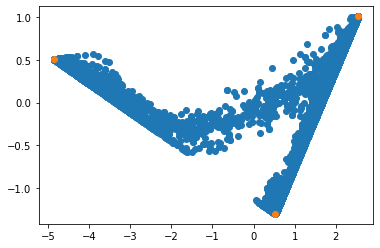

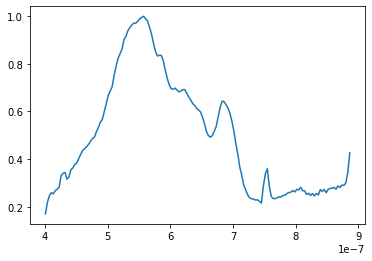

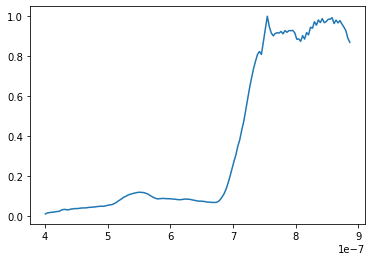

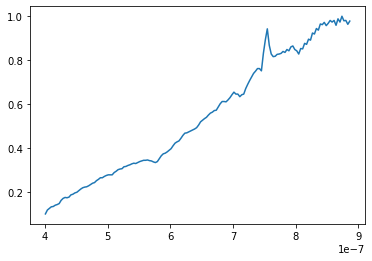

In [241]:
inst = nfindr(projected_data, R=3)
inst.run()

def spectres_elems():
    def plot_sp(i):
        i0 = inst.idx[i]
        display_spectrum(data.reshape((95, 95, 156)), (i0//95, i0%95))
    
    psp = np.vectorize(plot_sp,otypes=[float]) # https://github.com/numpy/numpy/issues/8758
    psp(np.arange(3))

spectres_elems()

# 4. Détermination des abondances

Nous cherchons maintenant à identifier les abondances de chacun des spectres, c'est à dire à déterminer, en chaque point, quelle est la proportion relative de chacun des spectres élémentaires identifiés dans l'étape précédente. Pour ce faire, nous cherchons à résoudre, à chaque pixel de l'image, le problème d'optimisation suivant:

$$
\alpha := \arg \min \| Y[x, y] - \sum_{i = 1}^3 \alpha _{i}[x, y] m_i \|^2
$$

sous les contraintes 

$$
\forall i = 1,2,3, \quad \alpha_i \geq 0
$$

et 

$$
\sum_{i = 1}^3 \alpha_i = 1.
$$

Pour résoudre ce problème, appliquer un algorithme de descente de gradient projeté, tel que décrit dans les slides.

In [242]:
class projected_gradient:

    """
    Projected gradient descent implementation for solving
    minimize ||Ma - y||^2 s.t 0 <= a <= 1.
    """

    def __init__(self, M, y):

        """
        Constructor
        
        :param M: endmembers matrix
        :param y: spectra
        """
        
        self.M = M
        self.R = self.M.shape[1]
        self.D = self.R-1 # à revoir avec slides
        self.y = y
        self.a = np.zeros(self.R)[np.newaxis].T
        self.beta = 0.5
        self.alpha = 0.001 # choix arbitraire ?
        self.lambd = 1. # utilité lambda ?

    def iterate(self):

        """
        Iteration of the projected gradient descent algorithm
        """

        # Compute the gradient
        self.f = self.fun(self.a)
        self.ga = self.grad_fun()
        self.nga = norm(self.ga, 2)        
        
        # Proximal operator
        # Line search
        self.step_size()            

        self.a = self.proj(self.a - self.t*self.ga)

    def fun(self, a):
        v = np.squeeze((np.dot(self.M, a) - self.y).T)
        vr = np.dot(v,v) # attention ne pas confondre np.dot et np.matmul
        return vr

    def grad_fun(self):
        tmp = np.dot(self.M, self.a)-self.y
        return 2*np.dot(self.M.T, tmp)
                
    def step_size(self):
        self.t = 1
        while self.fun(self.a - self.t*self.ga) > (self.f - self.alpha*self.t*self.nga):
            self.t = self.beta * self.t    

    def proj(self, a):
        a[a > 1] = 1
        a[a < 0] = 0
        return a

    def run(self, eps, maxiter):

        """
        Run the proximal gradient algorithm

        :param eps: Requested precision 
        :param maxiter: Maximal number of iteration
        """

        for i in range(maxiter):
            self.iterate()
            if (self.nga < eps):
                break
            if (i==(maxiter-1)):
                print("maxiter reached with", self.nga)
        
        

In [243]:
def display_abundances(abundances):

    """
    Display the abundances maps

    :param abundances: Abundances map
    :type abunbances: Numpy array
    """

    im0 = plt.imshow(abundances[:,:,0])
    plt.gcf().colorbar(im0)
    plt.figure()

    im1 = plt.imshow(abundances[:,:,1])
    plt.gcf().colorbar(im1)
    plt.figure()

    im2 = plt.imshow(abundances[:,:,2])   
    plt.gcf().colorbar(im2) 

    plt.show()


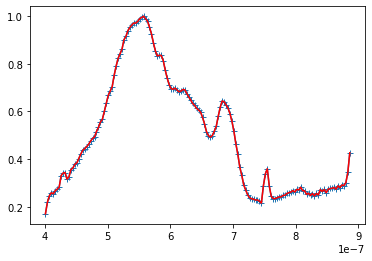

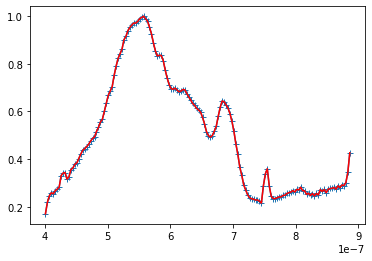

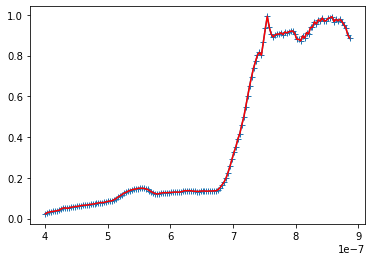

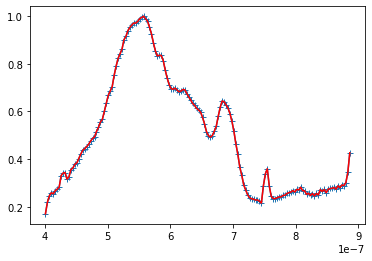

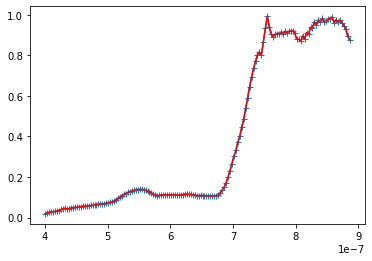

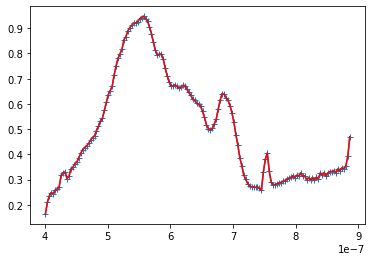

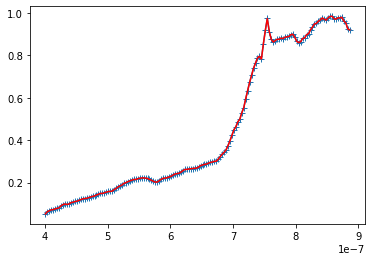

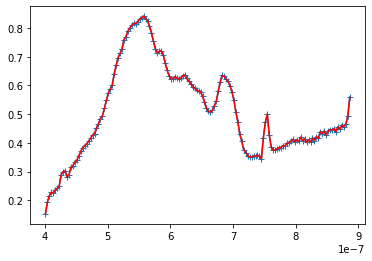

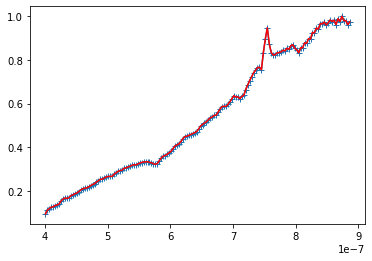

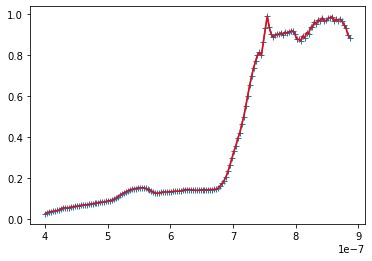

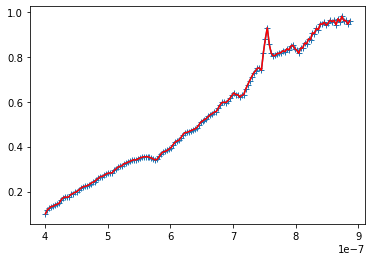

Abondances calculées


In [257]:
# Abundances estimation
endmembers = copy.deepcopy(inst.endmembers) # à voir dans partie précédente comment codé...
N, D = projected_data.shape

R = D + 1 # Number of endmembers
abundances = np.zeros((N, R))
    
# Trick for handling the sum-to-one constraint (see slides)
def process(z):
    em = copy.deepcopy(endmembers.T) # voir si vraiment utile
    vert = np.ones(R)

    m = np.vstack((em, vert))
    y = np.vstack((copy.deepcopy(projected_data[z][np.newaxis].T), np.array([1]))) # attention à la transpostion...

    pg = projected_gradient(m,y)
    pg.run(1e-2, 10000) # paramètres à optimiser
    res = pg.a.squeeze()
    
    if (z%1000==0):
        lb = display_spectrum(data.reshape((95, 95, 156)), (z//95, z%95), False)
        y_app = res[0]*data[i0]+res[1]*data[i1]+res[2]*data[i2]
        plt.plot(lb, y_app, '-', color = 'red')
        plt.show()

    abundances[z] = res

pro_v = np.vectorize(process)
pro_v(np.arange(N)) # sinon erreur si retourne element

print("Abondances calculées")

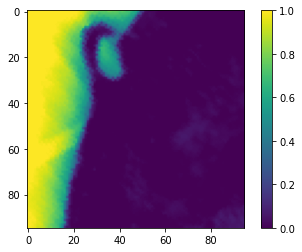

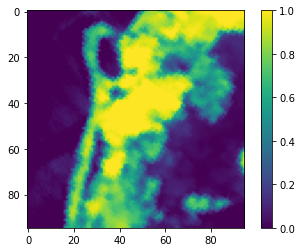

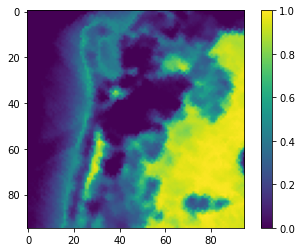

In [258]:
display_abundances(abundances.reshape((95, 95, 3)))